In [11]:
from models.snu_net import SNU_Net

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [12]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

#####
V[V < 0.3] = 0

In [13]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

weight_init = 0
decay_init = 1
threshold_init = 0.25
prop_init = 1

In [14]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

###
part_V_train = V_train[:50000].to(device)
part_train_E_neural = train_E_neural[:50000].to(device)
part_train_I_neural = train_I_neural[:50000].to(device)
###


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [15]:
model = SNU_Net(C_den, C_syn_e, C_syn_i,
                 weight_init, decay_init, threshold_init, prop_init,
                 device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

25


In [16]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, spk_pred = model(batch_E_neural, batch_I_neural)
        
    loss = torch.mean((V_pred - batch_V)**2)
    #loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_spk_pred = model(test_E_neural, test_I_neural) 
        train_V_pred, train_spk_pred = model(part_train_E_neural, part_train_I_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        train_mse = torch.mean((train_V_pred - part_V_train)**2).item()
        train_var = explained_variance_score(part_V_train.cpu().detach().numpy(), train_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_spk_pred).item(),
              np.round(torch.mean(model.decay_raw).item(), 6),
              np.round(torch.mean(model.threshold_raw).item() , 6),
              np.round(torch.mean(model.weight_raw).item() , 6),
              np.round(torch.mean(model.prop_raw).item() , 6)
             )


<ipython-input-16-d5de07ccc3e3>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -1.416366 0.052354 311.0 0.987422 0.286687 -0.003297 0.976298
199 -1.416366 0.052354 311.0 0.97823 0.313598 -0.009167 0.957617
299 -1.416366 0.052354 311.0 0.964772 0.351578 -0.013407 0.933955
399 -1.416366 0.052354 311.0 0.945187 0.406169 -0.025944 0.901377
499 -1.237473 0.048281 275.0 0.920791 0.467325 -0.041309 0.865125
599 -0.416347 0.030307 118.0 0.90143 0.496995 -0.050619 0.845593
699 -0.342236 0.028754 98.0 0.887367 0.506938 -0.054745 0.836664
799 -0.172465 0.025244 58.0 0.878648 0.512298 -0.057854 0.831607
899 -0.119241 0.024167 44.0 0.870101 0.515757 -0.062309 0.825115
999 -0.111055 0.024001 42.0 0.863229 0.517853 -0.066082 0.818465
1099 -0.124528 0.024309 38.0 0.856762 0.520472 -0.068742 0.812591
1199 -0.108094 0.023978 34.0 0.855942 0.515535 -0.072257 0.809275
1299 -0.104161 0.023894 34.0 0.853368 0.514188 -0.075171 0.805321
1399 -0.104161 0.023894 34.0 0.853051 0.512529 -0.079375 0.80053
1499 -0.09143 0.023632 32.0 0.850151 0.510791 -0.083327 0.794334
1599 -0.09143 0.023

KeyboardInterrupt: 

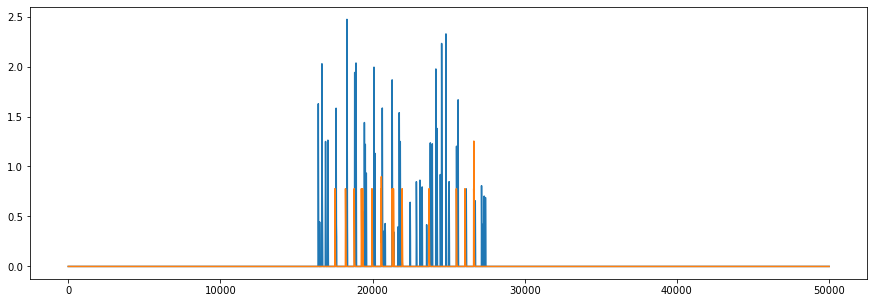

In [17]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())


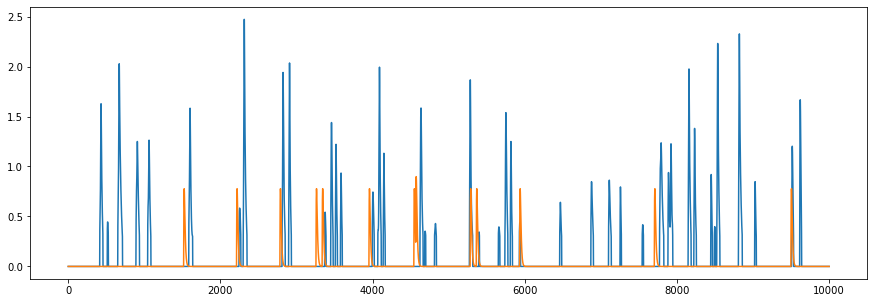

In [18]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


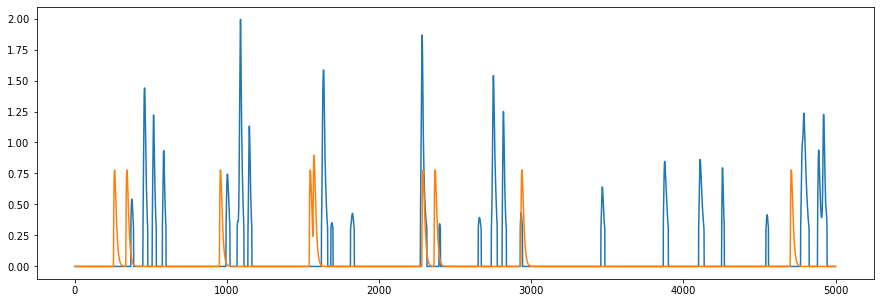

In [19]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:8000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:8000])


In [20]:
print(model.threshold_raw)

Parameter containing:
tensor([0.0300, 0.5951, 0.6058, 0.6028, 0.6041], device='cuda:0',
       requires_grad=True)
